Крестики-нолики
---
Обучение с подкреплением

<img style="float:left" src="board.png" alt="drawing" width="200"/>

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 3

### Состояние поля
---
Играют 2 игрока: p1 (крестик) и p2(нолик); свободные клетки инициализированы нулями

In [29]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
       # p1 делает первый ход
        self.playerSymbol = 1
        self.reward_tmp = []
        self.reward1 = []
        self.reward2 = []

    # хешируем состояние поля
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS*BOARD_ROWS))
        return self.boardHash

    def winner(self):
        # проверяем строки
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # проверяем столбцы
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # проверяем диагонали
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS-i-1] for i in range(BOARD_COLS)])
        diag_sum = max(diag_sum1, diag_sum2, key=abs)
        if diag_sum == 3:
            self.isEnd = True
            return 1
        if diag_sum == -3:
            self.isEnd = True
            return -1

        # ничья
        # нет доступных позиций
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # игра не закончена
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # должен быть кортежем
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # переключение на другого игрока
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # только если игра закончена
    def giveReward(self):
        result = self.winner()
        # вознаграждение
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
            self.reward_tmp.append(1)


        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
            self.reward_tmp.append(-1)


        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)
            self.reward_tmp.append(0)


    # обновление поля
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self, rounds=100):
        for i in range(rounds):
            if i%1000 == 0:
                print("Сыграно игр: {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # выполняем действие и обновляем состояние поля
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)

                # проверяем, не закончилась ли игра
                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # игра закончилась победой игрока p1 или ничьей
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # игра закончилась победой игрока p2 или ничьей
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    # игра против человека
    def play2(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # выполняем действие и обновляем состояние поля
            self.updateState(p1_action)
            self.showBoard()
            # проверяем, не закончена ли игра
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "выиграл! Смирись, смертный!")
                else:
                    print("Ничья! Неплохо, {}, но ты можешь лучше!".format(self.p2.name))
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)

                self.updateState(p2_action)
                self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        print(self.p2.name, ", победа за тобой! Похоже, вы настоящий мастер!")
                    else:
                        print("Ничья! Неплохо, {}, но ты можешь лучше!".format(self.p2.name))
                    self.reset()
                    break

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')

In [7]:
class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []  # записываем все занятые позиции
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # состояние -> значение
        self.reward = [0]

    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS*BOARD_ROWS))
        return boardHash

    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # выбираем рандомное действие
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        return action

    # добавляем сохранённое состояние
    def addState(self, state):
        self.states.append(state)

    # в конце игры обновляем значения состояний в обратном порядке
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
            reward = self.states_value[st]
        self.reward.append(self.reward[-1] + reward)

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file,'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [8]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions):
        while True:
            row = int(input("Введите номер строки для вашего хода:"))
            col = int(input("Введите номер столбца для вашего хода:"))
            action = (row, col)
            if action in positions:
                return action
            else:
                print("Кажется, вы выбрали занятую клетку!\nНомера строк и столбцов начинаются с 0.")

    def addState(self, state):
        pass

    def feedReward(self, reward):
        pass

    def reset(self):
        pass

### Обучение

In [30]:
p1 = Player("p1")
p2 = Player("p2")

st = State(p1, p2)
print("Обучение самого мощного игрока в крестики-нолики...")
st.play(50000)

Обучение самого мощного игрока в крестики-нолики...
Сыграно игр: 0
Сыграно игр: 1000
Сыграно игр: 2000
Сыграно игр: 3000
Сыграно игр: 4000
Сыграно игр: 5000
Сыграно игр: 6000
Сыграно игр: 7000
Сыграно игр: 8000
Сыграно игр: 9000
Сыграно игр: 10000
Сыграно игр: 11000
Сыграно игр: 12000
Сыграно игр: 13000
Сыграно игр: 14000
Сыграно игр: 15000
Сыграно игр: 16000
Сыграно игр: 17000
Сыграно игр: 18000
Сыграно игр: 19000
Сыграно игр: 20000
Сыграно игр: 21000
Сыграно игр: 22000
Сыграно игр: 23000
Сыграно игр: 24000
Сыграно игр: 25000
Сыграно игр: 26000
Сыграно игр: 27000
Сыграно игр: 28000
Сыграно игр: 29000
Сыграно игр: 30000
Сыграно игр: 31000
Сыграно игр: 32000
Сыграно игр: 33000
Сыграно игр: 34000
Сыграно игр: 35000
Сыграно игр: 36000
Сыграно игр: 37000
Сыграно игр: 38000
Сыграно игр: 39000
Сыграно игр: 40000
Сыграно игр: 41000
Сыграно игр: 42000
Сыграно игр: 43000
Сыграно игр: 44000
Сыграно игр: 45000
Сыграно игр: 46000
Сыграно игр: 47000
Сыграно игр: 48000
Сыграно игр: 49000


In [32]:
len(st.reward_tmp)

50000

In [33]:
counter = 0
analysis_rewards = []
for index, data in enumerate(st.reward_tmp):
    if data == 1:
        counter = counter + 1
    if index % 100 == 0:
        analysis_rewards.append(counter)
        counter = 0

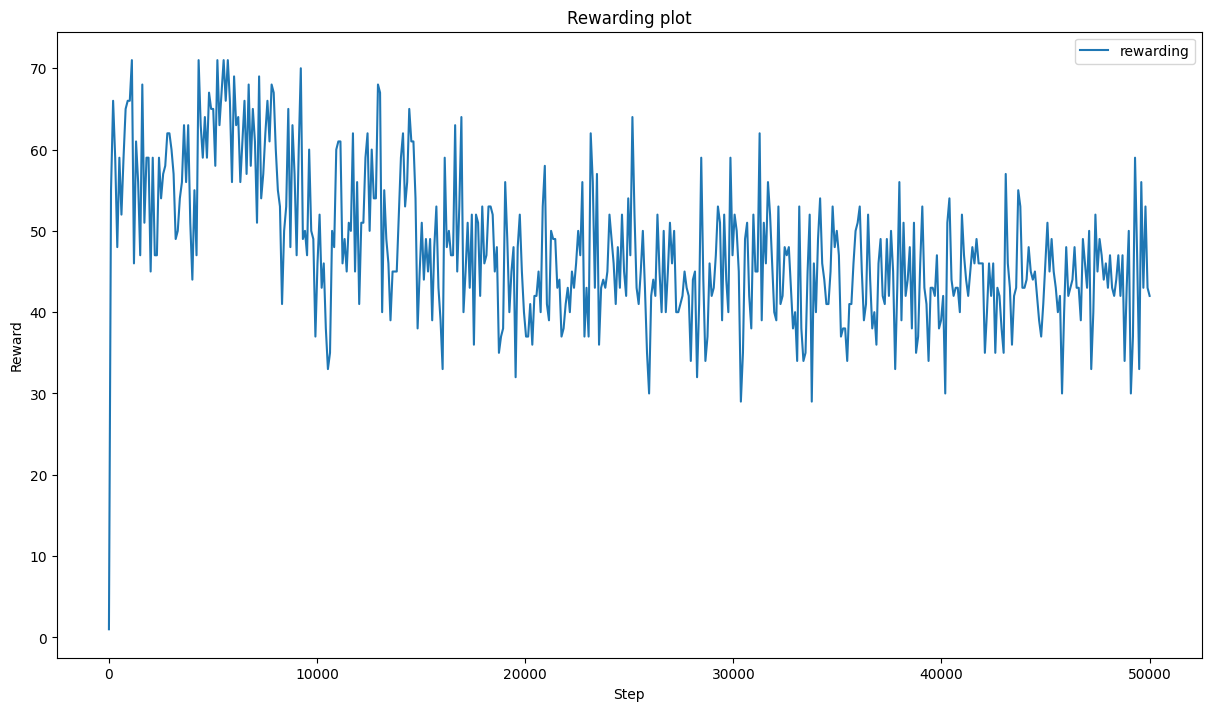

In [35]:
x = np.linspace(0, 50000, num=500)

fig, ax = plt.subplots(figsize=(12,7), layout='constrained')
ax.plot(x, analysis_rewards, label='rewarding')
ax.set_xlabel('Step')
ax.set_ylabel('Reward')
ax.set_title("Rewarding plot")
ax.legend()
plt.savefig('Rewarding plot')

In [ ]:
p1.savePolicy()
p2.savePolicy()

In [ ]:
p1.loadPolicy("policy_p1")

### Человек против компьютера

In [ ]:
## p1 = Player("Компьютер", exp_rate=0)
p1.loadPolicy("policy_p1")

p2 = HumanPlayer(input("Введите ваше имя:"))

st = State(p1, p2)
st.play2()

Введите ваше имя:
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
Введите номер строки для вашего хода:1
Введите номер столбца для вашего хода:1
-------------
| x |   |   | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   | x | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
Введите номер строки для вашего хода:0
Введите номер столбца для вашего хода:1
-------------
| x | o | x | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
-------------
| x | o | x | 
-------------
|   | o |   | 
-------------
|   | x |   | 
-------------
Введите номер строки для вашего хода:0
Введите номер столбца для вашего хода:1
Кажется, вы выбрали занятую клетку!
Номера строк и столбцов начинаются с 0.
Введите номер строки для вашего хода:1
Введите номер столбца для вашего хода:0
-------------
| x | o | x | 
-------------
| o | o |   | 
-------------
|   | x |   |